# Walkthrough notebook for the Empirical Trace Construction Module
Construct uncontaminated trace profiles for the first and second SOSS orders.

In [1]:
from astropy.io import fits
from matplotlib.colorbar import Colorbar
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sys import path
soss_path = '/Users/michaelradica/Documents/GitHub/jwst-mtl/'
path.insert(1, soss_path)

from SOSS.dms.soss_centroids import get_soss_centroids
from SOSS.extract.empirical_trace.utils import replace_badpix
from SOSS.extract.empirical_trace.empirical_trace import EmpiricalTrace

/Users/michaelradica/.anaconda3/envs/soss/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/michaelradica/Documents/GitHub/BEARS/BEARS_ref-files/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/michaelradica/.anaconda3/envs/soss/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/michaelradica/Documents/GitHub/BEARS/BEARS_ref-files/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/michaelradica/.anaconda3/envs/soss/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/michaelradica/Documents/GitHub/BEARS/BEARS_ref-files/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-034 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-045
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
from SOSS.extract.empirical_trace import _calc_interp_coefs

def simulate_wings(halfwidth=12):
    stand = _calc_interp_coefs.loicpsf([1.0*1e-6], save_to_disk=False,
                                           oversampling=1, pixel=256,
                                           verbose=False)[0][0].data
    stand = np.sum(stand[124:132, :], axis=0)


    maxx = np.nanmax(stand)
    stand /= maxx
    plt.plot(np.log10(stand))
    plt.axvline(256//2+halfwidth, ls=':')
    plt.axvline(256//2-halfwidth, ls=':')

    ystart = int(round(256//2-halfwidth, 0))
    yend = int(round(256//2+halfwidth, 0))
    wing = stand[yend:]
    ax = np.arange(256)
    pp = np.polyfit(ax[yend:], np.log10(wing), 7)
    wing = 10**(np.polyval(pp, ax[yend:]))
    plt.plot(ax[yend:], np.log10(wing))
    wing2 = stand[:ystart]
    pp = np.polyfit(ax[:ystart], np.log10(wing2), 7)
    wing2 = 10**(np.polyval(pp, ax[:ystart]))
    plt.plot(ax[:ystart], np.log10(wing2))
    
    return wing, wing2

def make_order2(o1sub, cen, mini=750, halfwidth=12):
    new_2 = np.zeros_like(o1sub)
    maxi = 2048
    
    wing, wing2 = simulate_wings()
    
    for i in range(2048):
        if i < mini:
            continue
        cen2 = int(round(cen['order 2']['Y centroid'][i], 0))
        if cen2+halfwidth > 255:
            if i < maxi:
                maxi = i
            continue  


        working_prof = np.copy(o1sub[:, i])
        maxx = np.nanmax(working_prof)
        working_prof /= maxx

        end = int(round((cen2+1*halfwidth), 0))
        start = int(round((cen2-1*halfwidth), 0))
        stitch = np.concatenate([wing2, working_prof[start:end], wing])

        stitch *= maxx

        stitch = np.interp(np.arange(256), np.arange(256)-256//2+cen2, stitch)

        new_2[:, i] = stitch  

    for i in range(mini):
        anchor_prof = new_2[:, mini]
        sc = cen['order 2']['Y centroid'][mini]
        ec = cen['order 2']['Y centroid'][i]
        working_prof = np.interp(np.arange(256), np.arange(256) - sc + ec, anchor_prof)
        new_2[:, i] = working_prof    

    for i in range(maxi, 2048):
        anchor_prof = new_2[:, maxi-1]
        sc = cen['order 2']['Y centroid'][maxi-1]
        ec = cen['order 2']['Y centroid'][i]
        working_prof = np.interp(np.arange(256), np.arange(256) - sc + ec, anchor_prof)
        new_2[:, i] = working_prof 
        
    return new_2

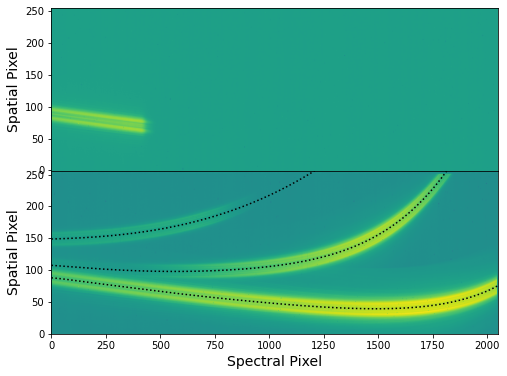

In [3]:
filepath = '/Users/michaelradica/transfer/IDTSOSS_clear_noisy_1_flatfieldstep.fits'
clear = fits.getdata(filepath, 1)
error = fits.getdata(filepath, 2)
clear = np.nansum(clear, axis=0)
filepath = '/Users/michaelradica/transfer/IDTSOSS_f277_noisy_1_flatfieldstep.fits'
f277 = fits.open(filepath)[1].data
f277 = np.nansum(f277, axis=0)

# Add a floor level such that all pixels are positive
# Are we introducing any biases by doing this?
floor = np.nanpercentile(clear, 0.1)
clear += -1*floor
floor_f277 = np.nanpercentile(f277, 0.1)
f277 += -1*floor_f277
# Do we want to be doing some background subtraction before this?

# Replace bad pixels.
clear = replace_badpix(clear, np.isnan(np.log10(clear)))
f277 = replace_badpix(f277, np.isnan(np.log10(f277)))

# Get the trace centroids for all three orders.
cen = get_soss_centroids(clear, subarray='SUBSTRIP256')

# Plot the data frames
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow(np.log10(f277), origin='lower', aspect='auto')
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow(np.log10(clear), origin='lower', aspect='auto')
ax2.plot(cen['order 1']['X centroid'], cen['order 1']['Y centroid'], ls=':', c='black')
ax2.plot(cen['order 2']['X centroid'], cen['order 2']['Y centroid'], ls=':', c='black')
ax2.plot(cen['order 3']['X centroid'], cen['order 3']['Y centroid'], ls=':', c='black')
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)
ax2.set_ylim(0, 256)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

/Users/michaelradica/Documents/GitHub/jwst-mtl/SOSS/extract/empirical_trace/empirical_trace.py:90: UserWarning: max_iter has been set to 0 - not iterating is inadvisable, and will lead to inaccurate trace solutions.
  warnings.warn(warn_msg)


Starting the Empirical Trace Construction module.

 Initial processing...
  Getting trace centroids...


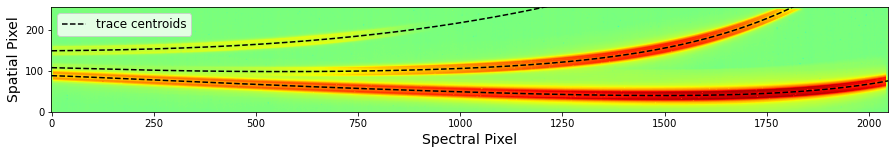

 
Constructing first pass trace models...
  Starting the first order trace model...
   Calibrating trace widths...


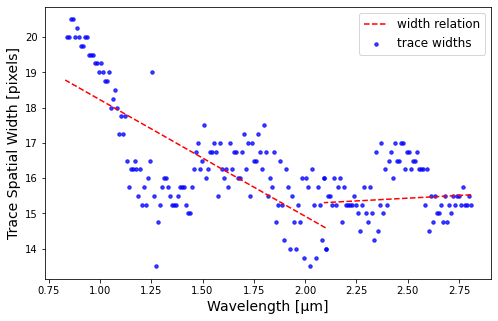

   Getting anchor profiles...


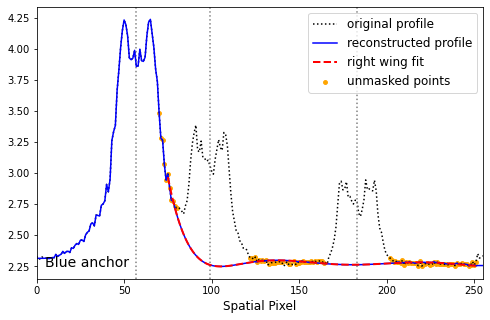

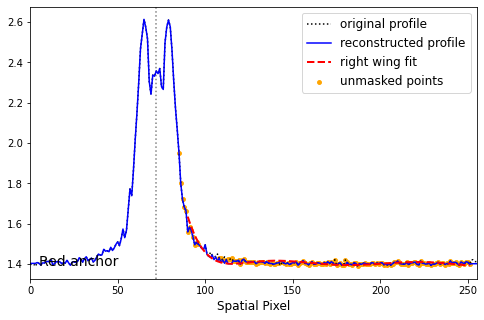

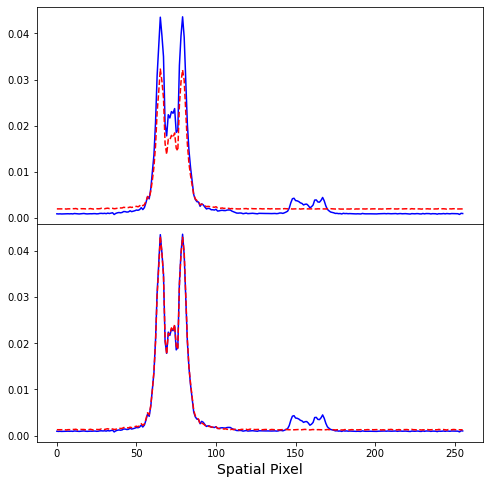

   Interpolating trace...


100%|██████████| 361/361 [00:00<00:00, 1677.00it/s]

   Stitching data and reconstructing wings...



100%|██████████| 373/373 [00:10<00:00, 35.88it/s]

   Rescaling first order to native flux level...



100%|██████████| 2048/2048 [00:12<00:00, 169.92it/s]


In [4]:
bad_pix = np.isnan(clear)
etrace = EmpiricalTrace(clear, f277, bad_pix, verbose=3)
etrace.build_empirical_trace(normalize=False, max_iter=0)

In [5]:
# Add back floor that was subtracted off and column normalize
etrace.order1 += floor
# etrace.order1 /= np.sum(etrace.order1, axis=0)

# etrace.order2 += floor
# etrace.order2 /= np.sum(etrace.order2, axis=0)

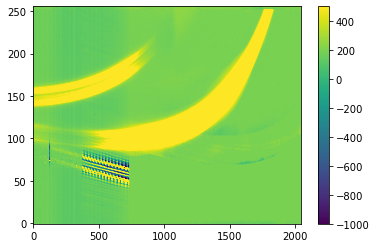

In [6]:
# subtract off order 1
o1sub = clear - etrace.order1
plt.imshow(o1sub, origin='lower', aspect='auto', vmin=-1e3, vmax=5e2)
plt.colorbar()
plt.show()

In [23]:
# Get sim reference profiles
order1 = fits.getdata('/Users/michaelradica/transfer/ref_specprofile.fits', 1)
binned_array = order1[40:-40, 40:-40].reshape(256, 2, 2048, 2)
order1 = binned_array.mean(-1).sum(1)
order1 /= np.sum(order1, axis=0)
order2 = fits.getdata('/Users/michaelradica/transfer/ref_specprofile.fits', 2)
binned_array = order2[40:-40, 40:-40].reshape(256, 2, 2048, 2)
order2 = binned_array.mean(-1).sum(1)
order2 /= np.sum(order2, axis=0)

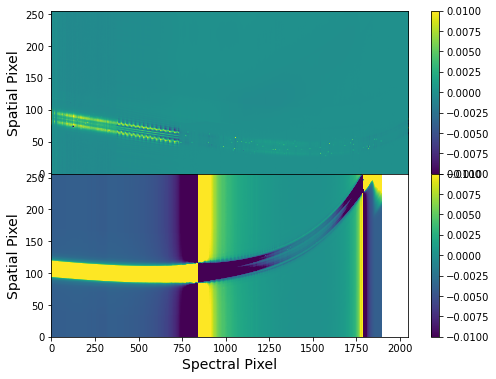

In [7]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow((order1 - etrace.order1), origin='lower', aspect='auto', vmax=0.01, vmin=-0.01)
plt.colorbar()
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow((order2 - etrace.order2), origin='lower', aspect='auto', vmax=0.01, vmin=-0.01)
plt.colorbar()
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)

plt.xlim(0, 2048)
plt.ylim(0, 256)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

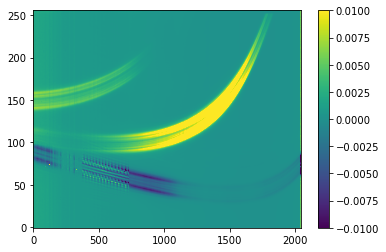

In [9]:
# Column normalize clear frame as best as possible (using only order 1)
halfwidth = 12
end = int(round(np.max(cen['order 1']['Y centroid']) + halfwidth, 0)) 
cc = clear / np.nansum(clear[:end], axis=0)

# subtract off order 1
o1sub = cc - etrace.order1
plt.imshow(o1sub, origin='lower', aspect='auto', vmin=-0.01, vmax=0.01)
plt.colorbar()

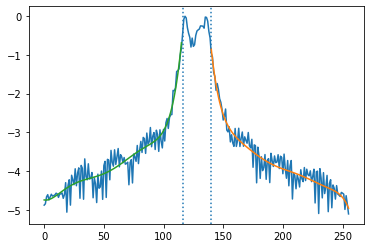

In [20]:
# Make order 2 model
new_2 = make_order2(o1sub, cen)
ttt = (new_2/np.nansum(new_2, axis=0))

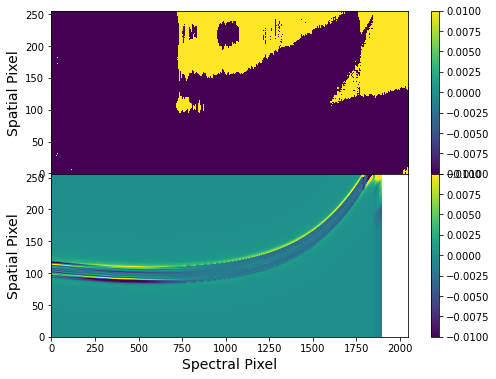

In [24]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow((order1 - etrace.order1), origin='lower', aspect='auto', vmax=0.01, vmin=-0.01)
plt.colorbar()
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow((order2 - ttt), origin='lower', aspect='auto', vmax=0.01, vmin=-0.01)
plt.colorbar()
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)

plt.xlim(0, 2048)
plt.ylim(0, 256)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

(80.0, 130.0)

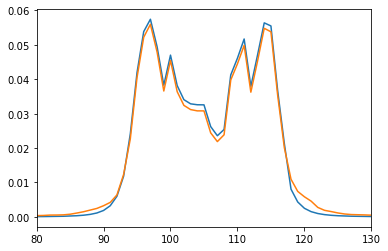

In [12]:
plt.plot((ttt[:, 1000]))
plt.plot((order2[:, 1000]))
#plt.ylim(-2, -1)
plt.xlim(80, 130)

CV3

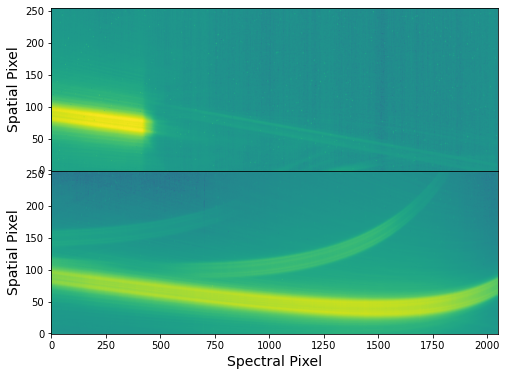

In [13]:
filepath = '/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Input_Files/cv3_clear.fits'
clear_cv3 = fits.getdata(filepath, 0)[::-1]
filepath = '/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Input_Files/cv3_f277.fits'
f277_cv3 = fits.getdata(filepath, 0).transpose()[::-1, ::-1]

# Add a floor level such that all pixels are positive
floor_cv3 = np.nanpercentile(clear_cv3, 0.1)
clear_cv3 += -1*floor_cv3
floor_f277_cv3 = np.nanpercentile(f277_cv3, 0.1)
f277_cv3 += -1*floor_f277_cv3

# Replace bad pixels.
clear_cv3 = replace_badpix(clear_cv3, np.isnan(np.log10(clear_cv3)))
f277_cv3 = replace_badpix(f277_cv3, np.isnan(np.log10(f277_cv3)))

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow(np.log10(f277_cv3), origin='lower', aspect='auto')
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow(np.log10(clear_cv3), origin='lower', aspect='auto')
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

/Users/michaelradica/Documents/GitHub/jwst-mtl/SOSS/extract/empirical_trace/empirical_trace.py:89: UserWarning: max_iter has been set to 0 - not iterating is inadvisable, and will lead to inaccurate trace solutions.
  warnings.warn(warn_msg)



Starting the Empirical Trace Construction module.

 Initial processing...
  Replacing bad pixels...


0it [00:00, ?it/s]
0it [00:00, ?it/s]


  Getting trace centroids...


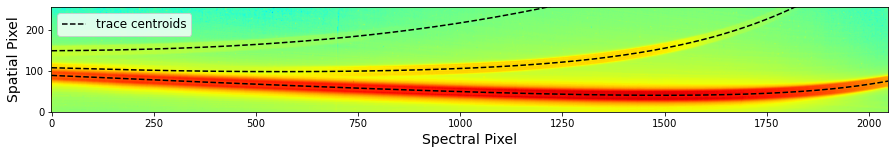

 
Constructing first pass trace models...
  Starting the first order trace model...
   Calibrating trace widths...


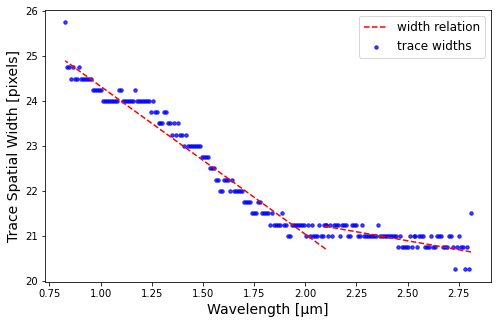

   Getting anchor profiles...


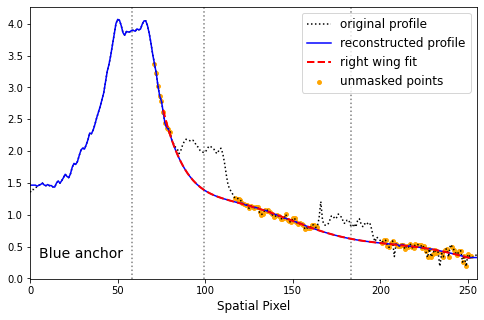

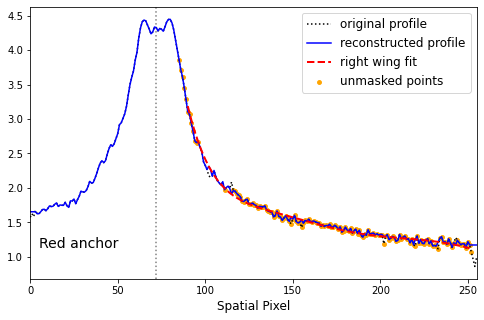

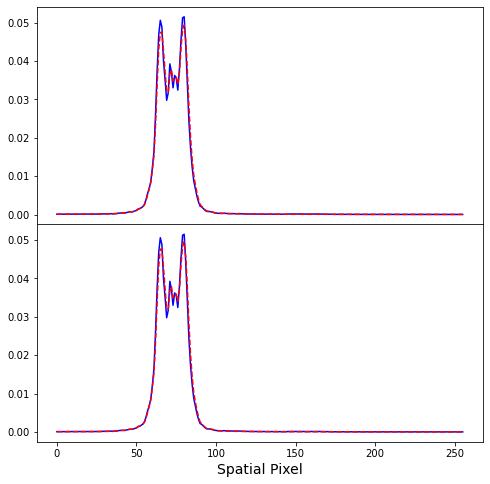

   Interpolating trace...


100%|██████████| 361/361 [00:00<00:00, 3746.59it/s]


   Stitching data and reconstructing wings...


100%|██████████| 373/373 [00:10<00:00, 36.25it/s]


   Rescaling first order to native flux level...


100%|██████████| 2048/2048 [00:10<00:00, 193.34it/s]


  Building the second order trace model...
   Reconstructing oversubtracted wings...


100%|██████████| 2048/2048 [00:10<00:00, 189.43it/s]


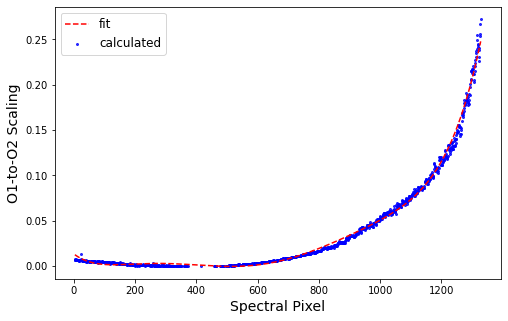

   Dealing with oversubtracted cores...
   Smoothing...


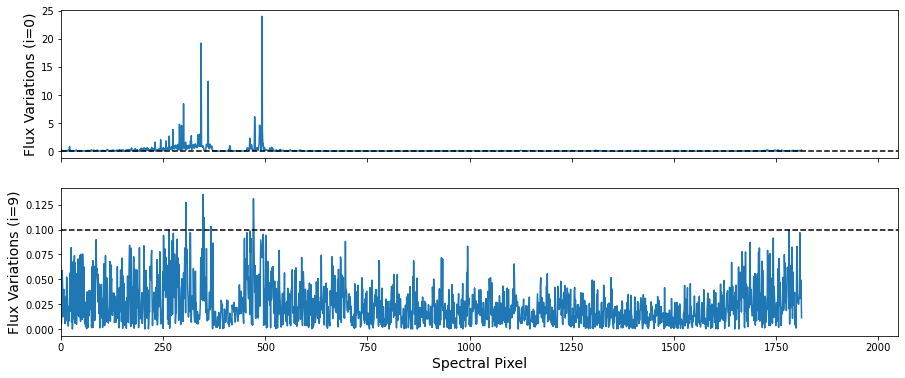

 First pass models complete.
 Adding padding to the spectral axis...


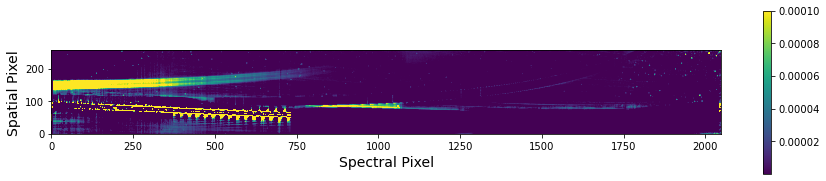


Done.


In [14]:
bad_pix = np.isnan(clear_cv3)
etrace_cv3 = EmpiricalTrace(clear_cv3, f277_cv3, bad_pix, verbose=3)
etrace_cv3.build_empirical_trace(normalize=False, max_iter=0)

In [15]:
# Add back floor that was subtracted off and column normalize
etrace_cv3.order1 += floor_cv3
etrace_cv3.order1 /= np.sum(etrace_cv3.order1, axis=0)

etrace_cv3.order2 += floor_cv3
etrace_cv3.order2 /= np.sum(etrace_cv3.order2, axis=0)

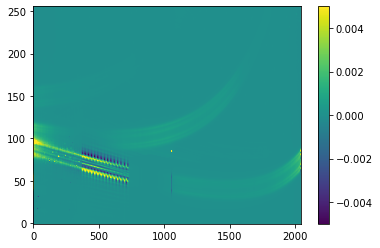

In [16]:
halfwidth = 12
end = int(round(np.max(cen['order 1']['Y centroid']) + halfwidth, 0)) 
cc = clear_cv3 / np.nansum(clear_cv3[:end], axis=0)
o1sub = cc - etrace_cv3.order1
plt.imshow(o1sub, origin='lower', aspect='auto', vmin=-0.005, vmax=0.005)
plt.colorbar()

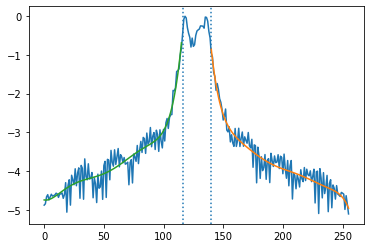

In [17]:
new_2 = make_order2(o1sub, cen)
ttt = (new_2/np.nansum(new_2, axis=0))

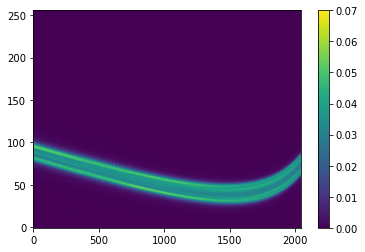

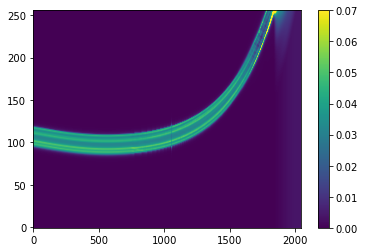

In [18]:
plt.imshow(etrace_cv3.order1, origin='lower', aspect='auto', vmin=0, vmax=0.07)
plt.colorbar()
plt.show()

plt.imshow(ttt, origin='lower', aspect='auto', vmin=0, vmax=0.07)
plt.colorbar()
plt.show()

The Empirical Trace Contruction module is accessed through the ```EmpiricalTrace``` class. Specifically, via calling its ```build_empirical_trace``` method after initalization. The two required arguments for the ```EmpiricalTrace``` class are a GR700XD/CLEAR exposure, as well as a bad pixel mask (first and third arguments respectively). 

It is recommended to include an exposure with the F277W filter in all NIRISS/SOSS observing programs, as this allows for a more accurate trace reconstruction in the region where the first two diffraction orders overlap. An F277W exposure can be passed to ```EmpiricalTrace``` as the second argument. If no F277W exposure is available, pass ```None``` in its place.

```EmpiricalTrace``` takes two optional arguments which control additional processing which can be done after the uncontaminated profiles are produced.
 - ```pad```: tuple, default (0, 0). Amount of padding to include (in native pixels) in the spatial and spectral directions, respectively.
 - ```oversample```: int, default 1. Oversampling factor. Oversampling will be equal in the spectral and spatial directions.
 
Additionally, the optional argument ```verbose```, governs the level of verbosity. There are 4 verbose levels available: 
 0. Silent (default).
 1. Show progress prints.
 2. Show both progress prints and bars.
 3. Show all of progress prints, progress bars, and diagnostic plots.
 
Two additional optional arguments can be passed to ```build_empirical_trace``` when calling the method:
 - ```normalize```: bool, default True. Whether to column normalize the final spatial profiles such that the flux in each column sums to one.
 - ```max_iter``` : int, default 1. The number of refinement iterations to perform on the spatial profiles. It is not recommended to set this argument to zero and not iterate. This will lead to highly inaccurate spatial profiles. 

In [38]:
# Initalize an EmpiricalTrace instance for a SUBSTRIP256 dataset with an F277W exposure.
bad_pix = np.isnan(clear)
etrace = EmpiricalTrace(clear, None, bad_pix, verbose=1)

In [39]:
# Run the empirical trace construction.
# Do not normalize in order to make direct comparisons with the original CLEAR dataframe.
etrace.build_empirical_trace(normalize=True)

Starting the Empirical Trace Construction module.

 Initial processing...
  Replacing bad pixels...
  Getting trace centroids...
 
Constructing first pass trace models...
  Starting the first order trace model...
   Calibrating trace widths...
   Getting anchor profiles...
   Interpolating trace...
   Stitching data and reconstructing wings...
   Rescaling first order to native flux level...
  Building the second order trace model...
   Reconstructing oversubtracted wings...
   Smoothing...
 First pass models complete.
 
Starting spatial profile refinement...
 iteration 1/1
  Refining the first order...
  Refining the second order...
   Reconstructing oversubtracted wings...
   Smoothing...
 Adding padding to the spectral axis...

Done.


To save the trace profiles to a file, use the ```save_to_file``` method. This method accepts the optional ```filename``` argument to specify the file to which the profiles will be written. If no filename is provided, it will default to 'SOSS_2D_profile_{subarray}.fits'.

Regardless of whether the uncontaminated trace profiles are written to a file, they are stored as attributes to the ```EmpiricalTrace``` object and can be accessed via the ```order1``` and ```order2``` attributes respectively. 

In [40]:
etrace.save_to_file()

Saving trace profiles to file SOSS_2D_profile_SUBSTRIP256_os=1_pad=0.fits...


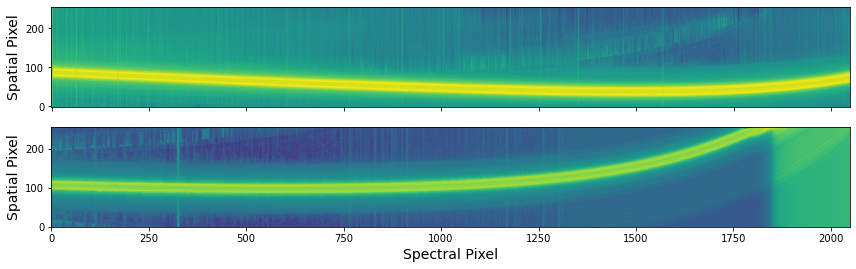

In [36]:
# Visualize the reonconstructed data frames
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
ax1.imshow(np.log10(etrace.order1), origin='lower')
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
ax2.imshow(np.log10(etrace.order2), origin='lower')
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)
ax2.set_xlim(0, 2048)
ax2.set_ylim(0, 256)

fig.tight_layout()

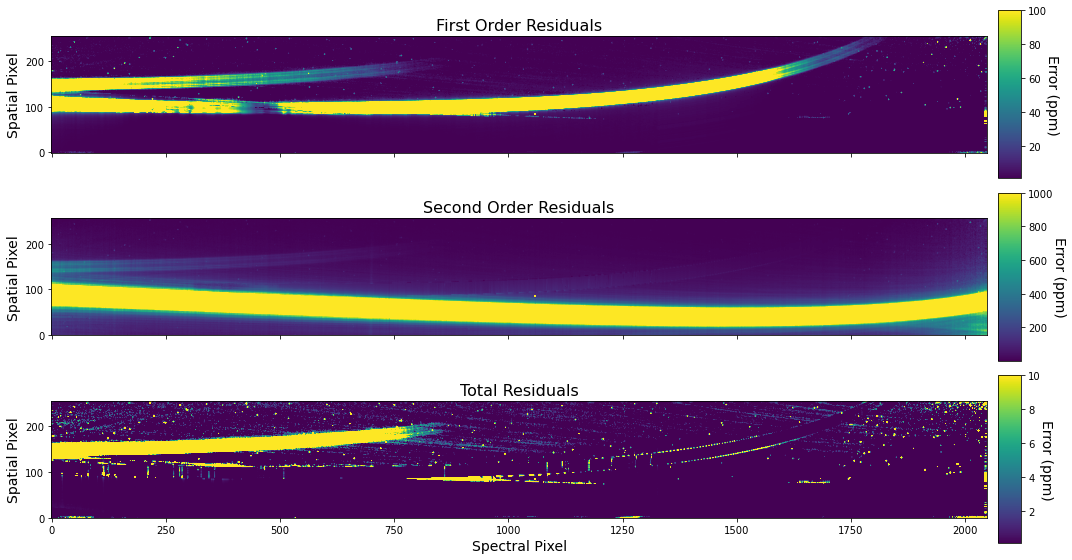

In [8]:
# Compare the reconstructed profiles to the original data.
# Residuals are shown as a fraction of the total column flux.
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 0.025])

ax1 = plt.subplot(gs[0, 0])
im1 = ax1.imshow((clearr - (etrace.order1))/np.nansum(clearr, axis=0)*1e6, origin='lower',
                 vmin=1, vmax=1e2)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.set_title('First Order Residuals', fontsize=16)

ax2 = plt.subplot(gs[0, 1])
cb = Colorbar(ax=ax2, mappable=im1, orientation='vertical', ticklocation='right')
cb.set_label(r'Error (ppm)', labelpad=12, rotation=270, fontsize=14)

ax3 = plt.subplot(gs[1, 0])
im2 = ax3.imshow((clearr - (etrace.order2))/np.nansum(clearr, axis=0)*1e6, origin='lower',
                 vmin=1, vmax=1e3)
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_ylabel('Spatial Pixel', fontsize=14)
ax3.set_title('Second Order Residuals', fontsize=16)

ax4 = plt.subplot(gs[1, 1])
cb = Colorbar(ax=ax4, mappable=im2, orientation='vertical', ticklocation='right')
cb.set_label(r'Error (ppm)', labelpad=12, rotation=270, fontsize=14)

ax5 = plt.subplot(gs[2, 0])
im3 = ax5.imshow((clearr - (etrace.order1+etrace.order2))/np.nansum(clearr, axis=0)*1e6,
                 origin='lower', vmin=0.1, vmax=10)
ax5.set_xlabel('Spectral Pixel', fontsize=14)
ax5.set_ylabel('Spatial Pixel', fontsize=14)
ax5.set_title('Total Residuals', fontsize=16)

ax6 = plt.subplot(gs[2, 1])
cb = Colorbar(ax=ax6, mappable=im3, orientation='vertical', ticklocation='right')
cb.set_label(r'Error (ppm)', labelpad=12, rotation=270, fontsize=14)

fig.tight_layout()

In each case, the appropriate order is well subtracted, and residuals (outside of the third order) are generally <10ppm of total column flux. 

Subarrays 'FULL' and 'SUBSTRIP96' are also supported. However, in the case of SUBSTRIP96, only a first order profile is able be produced. It is then recommended to use a reference file and the simple solver in order to obtain a 2D profile for the second order. 

In [9]:
# Initalize an EmpiricalTrace instance for a SUBSTRIP256 dataset with an F277W exposure.
bad_pix = np.isnan(clear)
etrace = EmpiricalTrace(clear, None, bad_pix, verbose=3)

/Users/michaelradica/Documents/GitHub/jwst-mtl/SOSS/extract/empirical_trace/empirical_trace.py:85: UserWarning: max_iter has been set to 0 - not iterating is inadvisable, and will lead to inaccurate trace solutions.
  warnings.warn(warn_msg)



Starting the Empirical Trace Construction module.

 Initial processing...
  Replacing bad pixels...


100%|██████████| 6144/6144 [00:00<00:00, 8522.45it/s]


  Getting trace centroids...


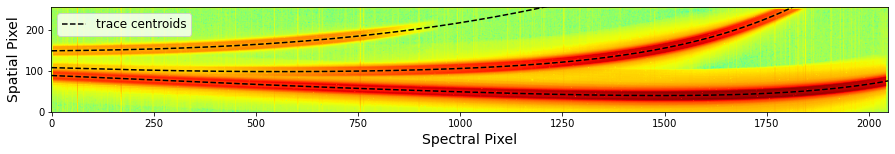

 
Constructing first pass trace models...
  Starting the first order trace model...
   Calibrating trace widths...


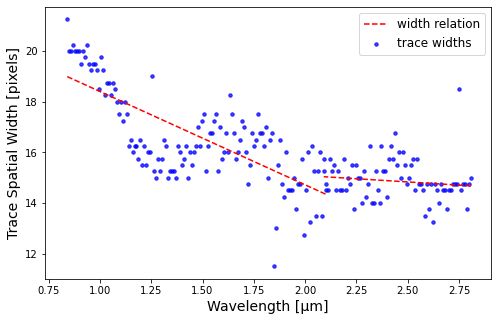

   Getting anchor profiles...


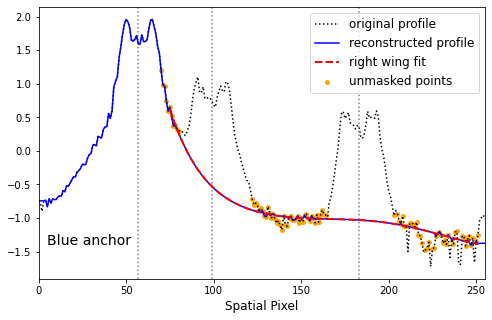

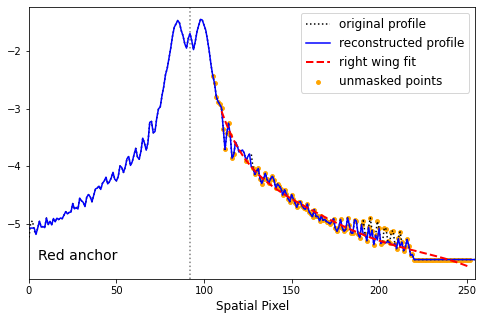

   Interpolating trace...


100%|██████████| 734/734 [00:00<00:00, 5164.54it/s]


   Stitching data and reconstructing wings...


100%|██████████| 1315/1315 [00:32<00:00, 40.36it/s]


   Rescaling first order to native flux level...


100%|██████████| 2048/2048 [00:04<00:00, 439.03it/s]


  Building the second order trace model...
   Reconstructing oversubtracted wings...


100%|██████████| 2048/2048 [00:09<00:00, 220.02it/s]


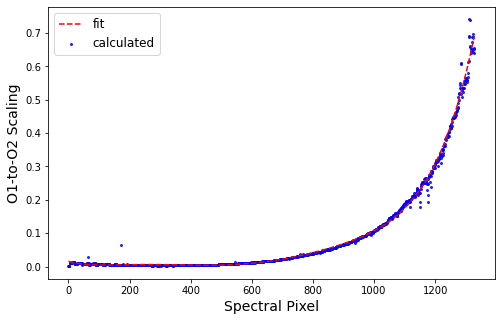

 First pass models complete.
 Adding padding to the spectral axis...


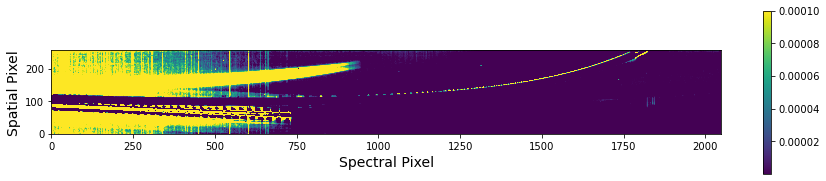


Done.


In [10]:
etrace.build_empirical_trace(normalize=True, max_iter=0)

In [49]:
etrace.save_to_file()

Saving trace profiles to file SOSS_2D_profile_SUBSTRIP256_os=1_pad=0.fits...


In [11]:
clear = fits.getdata('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Input_Files/cv3_clear.fits', 0)
f277w = fits.getdata('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Input_Files/cv3_f277.fits', 0).transpose()

In [13]:
# Preform a rough background subtraction.
clear -= np.nanpercentile(clear, 1, axis=0)
f277w -= np.nanpercentile(f277w, 1, axis=0)

# Replace bad pixels.
clear = replace_badpix(clear, np.isnan(clear))
f277w = replace_badpix(f277w, np.isnan(clear))

In [57]:
clear = fits.getdata('/Users/michaelradica/ref_specprofile.fits', 1)

In [58]:
binned_array = clear[40:-40, 40:-40].reshape(256, 2, 2048, 2)
clear = binned_array.mean(-1).sum(1)

In [63]:
trace_widths3 = []
for i in range(2048):
    prof = clear[:, i]
    prof = np.interp(np.linspace(0, 255, 256*10), np.arange(256),
                     prof)
    # Sort the flux values in the profile.
    prof_sort = np.argsort(prof)
    # To mitigate the effects of any outliers, use the median of the 5
    # highest flux values as the maximum.
    inds = prof_sort[-5:]
    maxx = np.nanmedian(prof[inds])
    # Count how many pixels have flux greater than half this value.
    above_av = np.where(prof >= maxx/2)[0]
    trace_widths3.append(len(above_av)/10)

(18.0, 27.0)

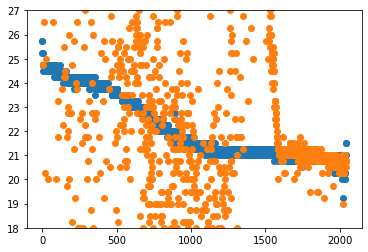

In [34]:
plt.scatter(np.arange(2048)[::-1], trace_widths)
plt.scatter(np.arange(2048), trace_widths2)
plt.ylim(18, 27)

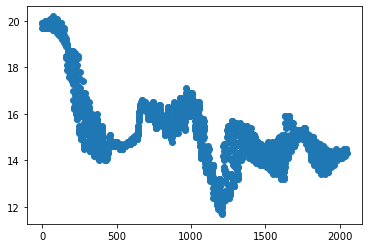

In [64]:
plt.scatter(np.arange(2048)[::-1], trace_widths3)

In [90]:
import numpy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*numpy.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [0.1, 100., 10.]

s = []
for i in range(2048):
    coeff, var_matrix = curve_fit(gauss, np.arange(256), clear[:, i], p0=p0)

    # Get the fitted curve
    #hist_fit = gauss(np.arange(256), *coeff)
    s.append(np.abs(coeff[2]))
#     plt.plot(np.arange(256), clear[:, i], label='Test data')
#     plt.plot(np.arange(256), hist_fit, label='Fitted data')

#     # Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
#     print('Fitted mean = {}'.format(coeff[1]))
#     print('Fitted standard deviation = {}'.format(coeff[2]))

#     plt.show()

(9.2, 10.0)

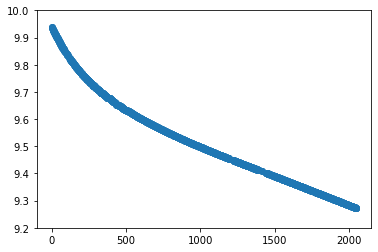

In [98]:
plt.scatter(np.arange(2048)[::-1], s)
plt.ylim(9.2, 10)
# Cannot use this for absolute widths, but can use it for relative widths!